1


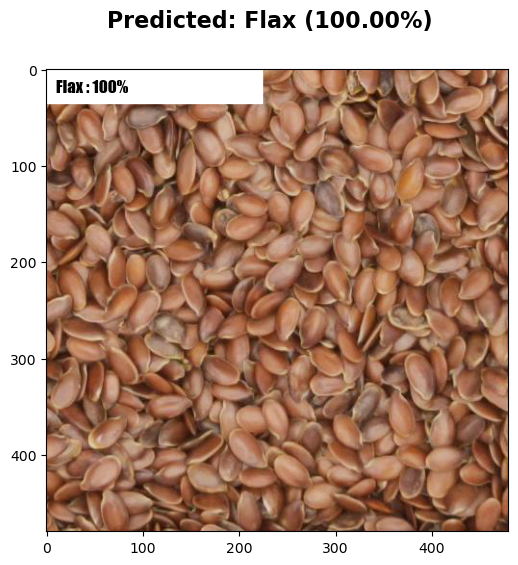

In [2]:
import torch
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from PIL import Image

# Определяем устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Функция для предсказания
def predict_one_sample(model, input_tensor):
    model.eval()

    with torch.no_grad():
        input_tensor = input_tensor.to(DEVICE)
        outputs = model(input_tensor).cpu()
    
    probs = torch.nn.functional.softmax(outputs, dim=-1).numpy()
    return probs

# Подготовка модели
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights).to(DEVICE)

for param in resnet.parameters():
    param.requires_grad = False

for layer in list(resnet.children())[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

# Модификация последнего fully connected слоя
num_ftrs = resnet.fc.in_features
num_classes = 45  # Количество классов вашей задачи должно быть 45
resnet.fc = torch.nn.Linear(num_ftrs, num_classes)
resnet.fc = resnet.fc.to(DEVICE)

# Загрузка обученных весов
model_path = 'model_weights_epoch_10.pth'
resnet.load_state_dict(torch.load(model_path, map_location=DEVICE))

# Список названий классов (пример)
class_names = ['barley', 'flax', 'oats', 'wheat'] # Замените на ваши классы

# Путь к изображению
image_path = "/Users/lerapolovinkina/PycharmProjects/ZernaCoursework/ZernaDataset/test/images/alzdvkvelonpdmwqocmghnzpkfslsleyghydpqhw.jpg"

# Создаем сетку для отображения
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

# Загружаем изображение
image = Image.open(image_path)

# Преобразуем изображение в тензор PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0)

# Получаем предсказание модели для изображения
prob_pred = predict_one_sample(resnet, image_tensor)
predicted_proba = np.max(prob_pred) * 100
y_pred = np.argmax(prob_pred)
print(y_pred)
# Получаем метку класса из списка названий классов
predicted_label = class_names[y_pred]

# Отображаем изображение
ax.imshow(image)

# Добавляем заголовок с предсказанием
plt.suptitle(f"Predicted: {predicted_label.capitalize()} ({predicted_proba:.2f}%)", fontsize=16, fontweight='bold')

# Добавляем текст с предсказанием
font0 = FontProperties()
font = font0.copy()
font.set_family("fantasy")
predicted_text = "{} : {:.0f}%".format(predicted_label.capitalize(), predicted_proba)
ax.add_patch(patches.Rectangle((0, 0), 224, 35, color='white'))
ax.text(10, 10, predicted_text, horizontalalignment='left', fontproperties=font,
        verticalalignment='top', fontsize=12, color='black', fontweight='bold')

plt.show()